In [1]:
import pandas as pd
import json
import numpy as np
import requests
import urllib
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import textdistance
import string
import re
from dateutil import parser
import time
import unidecode
from googletrans import Translator


In [2]:
with open('data/final/sampled_references_sv.json','r',encoding='utf-8') as f:
    json_sv = json.load(f)
    df = pd.DataFrame(json_sv)
df['verified'] = False
df.shape

(340, 10)

In [3]:
def norm_string(s):
    #return s.lower().translate(str.maketrans('', '', string.punctuation))
    return re.sub('\W+','', s).lower()

def compare(s1,s2):
    s1 = unidecode.unidecode(norm_string(s1))
    s2 = unidecode.unidecode(norm_string(s2))
    return textdistance.levenshtein.normalized_similarity(s1,s2)

## We check the netlocs to see what checks can be automatized

In [4]:
urlparse_df = df['url'].transform(urlparse)
urlparse_df = pd.DataFrame(urlparse_df.tolist(), index=urlparse_df.index)
df[['scheme','netloc','path','params','query','fragment']] = urlparse_df
pd.DataFrame(df['netloc'].value_counts()).reset_index().head(10)

,index,netloc
0,tools.wmflabs.org,143
1,libris.kb.se,94
2,sv.wikipedia.org,53
3,nvpub.vic-metria.nu,10
4,sok.riksarkivet.se,10
5,sync.nm.delorean.se,5
6,kulturarvsdata.se,4
7,viaf.org,3
8,calmview.musikverk.se,3
9,www.svenskagravar.se,3


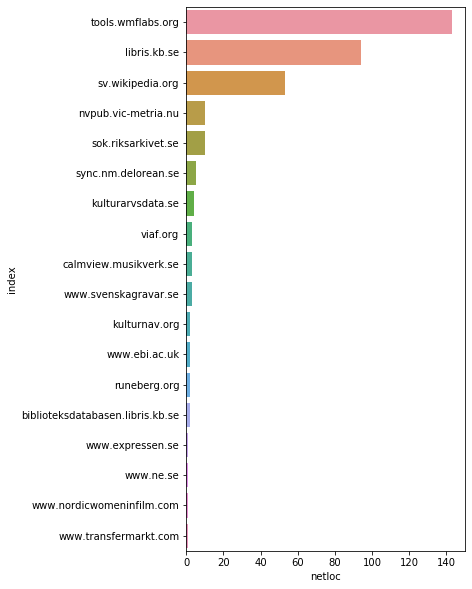

In [5]:
fig, ax = plt.subplots(1,1,figsize=(5,10))
sns.barplot(data = pd.DataFrame(df['netloc'].value_counts()).reset_index(),
           y = 'index',x='netloc', ax=ax)
plt.show()

## www.ebi.ac.uk
We see here that there are many types of predicates, but automating these many checks may be done.

Some here have the path for the api, some do not. We can only check those directed at the API, so we filter them. The ones filtered out are protein and gene databases which we'll check later.

### Article API

In [6]:
df_ebi = df[df['netloc'] == 'www.ebi.ac.uk']
df_ebi_api = df_ebi[df_ebi['path'] == '/europepmc/webservices/rest/search']
df_ebi_api['predicate'].value_counts(), df_ebi_api.shape[0]

(sida         1
 PubMed ID    1
 Name: predicate, dtype: int64,
 2)

In [7]:
def verify_ebi_api(row, verbose=True):
#for i, row in df_en_ebi_api.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    d = requests.get(row['url']).json()['resultList']['result']
    
    if compare(subject, d[0]['title']) < 0.9:
        if verbose:
            print(subject)
            print(d[0]['title'])
        #break
        return found
    if predicate == 'instans av':
        value = d[0]['pubTypeList']['pubType']
        if obj == 'vetenskaplig artikel' \
            and 'Journal Article' in value \
            or 'Case Reports' in value \
            or 'Editorial' in value \
            or 'Letter' in value:
            found = True            
    elif predicate == 'utgivningsdatum':
        value = d[0]['firstPublicationDate']
        if parser.parse(obj).date() == parser.parse(value).date():
            found = True
    elif predicate == 'publicerad i':
        obj = obj.replace('The BMJ','British medical journal')
        value = d[0]['journalInfo']['journal']['title']
        value = value.split(' = ')
        for v in value:
            if compare(obj, v) >= 0.6:
                found = True
    elif predicate == 'DOI':
        value = d[0]['doi']
        if compare(obj, value) >= 0.99:
            found = True
    elif predicate == 'kort författarnamn' or predicate == 'autor':
        value = d[0]['authorList']['author']
        for author in value:
            #if 'fullName' in author:
            #    print('Full name:',author['fullName'])
            #if 'firstName' in author:
            #    print('First and last names:',author['firstName'] + ' ' + author['lastName'])
            #print(obj)
            if 'fullName' in author and compare(obj, author['fullName']) >= 0.99:
                found = True
            elif 'firstName' in author and compare(obj, author['firstName'] + ' ' + author['lastName']) >= 0.99:
                found = True
    elif predicate == 'band':
        value = d[0]['journalInfo']['volume']
        if value == obj:
            found = True
    elif predicate == 'sida':
        value = d[0]['pageInfo']
        if value == obj:
            found = True
    elif predicate == 'nummer':
        value = d[0]['journalInfo']['issue']
        if value == obj:
            found = True
    elif predicate == 'PubMed ID':
        value = d[0]['id']
        if value == obj:
            found = True
    #elif predicate == 'author':
    #    value = d[0]['authorList']['author']
    elif predicate == 'titel':
        value = d[0]['title']
        if compare(obj, d[0]['title']) >= 0.9:
            found = True
    elif predicate == 'PMCID':
        value = d[0]['pmcid']
        if ('PMC'+obj) == value:
            found = True
    if not found and verbose:
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_ebi_api_verified = df_ebi_api.apply(verify_ebi_api,axis=1)
print('{}% are confirmed'.format(100*df_ebi_api_verified.sum()/len(df_ebi_api_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_ebi_api.index:
    df.loc[i,'verified'] = True
    
# Those not verified
df_ebi_api[df_ebi_api_verified == False]

100.0% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment


### The rest of ebi.ac.uk (genes and proteins)

Conclusion: Names in subject / object differ too much from those obtained in the APIs, and there seems to be great need of domain knowledge (biology) to navigate through the information, making automatically checking the API daunting and approaches manual effort.

## viaf.org

In [8]:
df_viaf = df[df['netloc'] == 'viaf.org']
df_viaf['predicate'].value_counts()

SELIBR ID              1
WorldCat Identities    1
NTA ID                 1
Name: predicate, dtype: int64

In [9]:
def verify_viaf(row, verbose=True):
#verbose = True
#for i, row in df_en_pubmed.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    
    viaf_id = row['url'].split('/')[-1]
    
    while 1:
        url = 'http://www.viaf.org/viaf/{}/viaf.json'.format(viaf_id)
        resp = requests.get(url)
        if resp.status_code == 502:
            continue
        else:
            break
    try:
        d = resp.json()
    except Exception:
        print(url)
        print(resp)
        return False
    try:
        if type(d['mainHeadings']['data']) is not list:
            d['mainHeadings']['data']= [d['mainHeadings']['data']]
        names = [name['text'] for name in d['mainHeadings']['data']]
        for to_add in ['mainHeadings/mainHeadingEl','x400s/x400','x500s/x500']:
            to_add = to_add.split('/')
            if to_add[0] in d:
                if type(d[to_add[0]][to_add[1]]) != list:
                    d[to_add[0]][to_add[1]] = [d[to_add[0]][to_add[1]]]
                names_i = [i['datafield']['subfield'] for i in d[to_add[0]][to_add[1]]]
                names_i = [n if type(n) == list else [n] for n in names_i]
                names_i = [item['#text'] for sublist in names_i for item in sublist]
                names += names_i
    except Exception:
        print(url)
        print(d)
        raise

    if all([compare(subject,name) < 0.9 for name in names]):
        if verbose:
            print(url)
            print(subject)
            print(names)
        #break
        return found
    
    non_flat_ids = [[s] if type(s) != list else s for s in [s['sources']['sid'] for s in d['mainHeadings']['data']]]
    flat_ids = [item for sublist in non_flat_ids for item in sublist]
    if 'xLinks' in d:
        xLinks = [i if type(i) == str else i['#text'] for i in d['xLinks']['xLink']] if type(d['xLinks']['xLink']) == list else d['xLinks']['xLink']
        if type(xLinks) != list:
            xLinks = [xLinks]
            
    if predicate == 'BNF ID':
        value = [i for i in flat_ids if i.startswith('BNF|')][0].split('|')[-1]
        if obj.startswith(value):
            found = True
    elif predicate == 'WorldCat Identities':
        value = [i for i in xLinks if i.startswith('https://www.worldcat.org/identities/')][0].split('/')[-1]
        if obj == value:
            found = True
    elif predicate == 'NTA ID':
        value = [i for i in flat_ids if i.startswith('NTA|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    elif predicate == 'GND ID':
        value = [i for i in flat_ids if i.startswith('DNB|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    elif predicate == 'VIAF':
        if obj in [viaf_id]:
            found = True
    elif predicate == 'LCAuth':
        value = [i for i in flat_ids if i.startswith('LC|')][0].split('|')[-1].replace(' ','')
        if obj in [value]:
            found = True
    elif predicate == 'födelsedatum':
        value = d['birthDate']
        if obj.startswith(value):
            found = True
    elif predicate == 'ISNI':
        value = [i for i in flat_ids if i.startswith('ISNI|')][0].split('|')[-1].replace(' ','')
        if obj.replace(' ','') in [value]:
            found = True
    elif predicate == 'SELIBR ID':
        value = [i for i in flat_ids if i.startswith('SELIBR|')][0].split('|')[-1].replace(' ','')
        if obj.replace(' ','') in [value]:
            found = True
    else:
        print(flat_ids)
    
    
    if not found and verbose:
        print(url)
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_viaf_verified = df_viaf.apply(verify_viaf,axis=1)
print('{}% are confirmed'.format(100*df_viaf_verified.sum()/len(df_viaf_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_viaf.index:
    df.loc[i,'verified'] = True

# Those not verified
df_viaf[df_viaf_verified == False]

100.0% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment


### tools.wmflabs.org

In [10]:
df_tools = df[df['netloc'] == 'tools.wmflabs.org']
df_tools['predicate'].value_counts()

K-samsök URI                          24
instans av                            22
kulturskyddsstatus                    21
land                                  20
geografiska koordinater               19
inom administrativt område            18
plats                                 16
har delar från klassen                 1
datum för grundande eller skapande     1
arkitekt                               1
Name: predicate, dtype: int64

In [11]:
tools_non_verifiable_predicates = ['arkitekt', 'har delar från klassen'
                                   ,'datum för grundande eller skapande']

def verify_tools(row, verbose=False):
#verbose = True
#for i, row in df_en_pubmed.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    
    tools_id = row['url'].split('srid=')[-1]
    
    while 1:
        url = row['url']
        resp = requests.get(url)
        if resp.status_code == 502:
            continue
        else:
            break
    try:
        d = resp.json()
    except Exception:
        print(url)
        print(resp)
        return False
    
    name = d['monuments'][0]['name']

    if compare(subject,name) < 0.7 and norm_string(subject) not in norm_string(name):
        if verbose:
            print(url)
            print(subject)
            print(name)
        #break
        return found
    
    if predicate == 'K-samsök URI':
        if obj.split('/')[-1] == tools_id:
            found = True
    elif predicate == 'instans av':
        if norm_string(obj) in norm_string(name):
            found = True
    elif predicate == 'geografiska koordinater':
        obj = re.split(r'[a-zA-Z\(\) ]+',obj)
        if obj[1] == str(d['monuments'][0]['lon']) and obj[2] == str(d['monuments'][0]['lat']):
            found = True
    elif predicate == 'land':
        if d['monuments'][0]['adm0'] == 'se' and obj == 'Sverige':
            found = True
    elif predicate == 'kulturskyddsstatus' and obj == 'monument i Fornminnesregistret':
        found = True
    elif predicate == 'inom administrativt område':
        value = obj.split(' kommun')[0]
        if value in [d['monuments'][0]['adm2'], d['monuments'][0]['adm2']+'s']:
            found = True
    elif predicate == 'plats':
        value = obj.split(' ')[0]
        if norm_string(value) in norm_string(d['monuments'][0]['name']):
            found = True
        else:
            value = obj.split('s ')[0]
            if norm_string(value) in norm_string(d['monuments'][0]['name']):
                found = True
    elif predicate in tools_non_verifiable_predicates:
        found = False
        value = 'can not verify predicate'
    else:
        print('predicate not treated')
    
    
    if not found and verbose:
        print(url)
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_tools_verified = df_tools.apply(verify_tools,axis=1)
print('{}% are confirmed'.format(100*df_tools_verified.sum()/len(df_tools_verified)))

# Mark them in the original df so that we don't crowdsource them
#for i in df_tools.index:
#    if df.loc[i,'predicate'] not in tools_non_verifiable_predicates:
#        df.loc[i,'verified'] = True
        
for i in df_tools[df_tools_verified == True].index:
    df.loc[i,'verified'] = True

# Those not verified
df_tools[df_tools_verified == False]

95.8041958041958% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment
11,3903bcde3ea394983fc324a02be917cb7790fa78,https://tools.wmflabs.org/heritage/api/api.php...,{'stated in': 'wikibase-item:>Monuments databa...,sv,Q26256922-C8E9175D-36AA-41A2-89A6-247DE27AA51C,Linghallen,arkitekt,Torben Grut,0,False,https,tools.wmflabs.org,/heritage/api/api.php,,action=search&format=json&srcountry=se-bbr&srl...,
13,23f72cc523197842836efcda06878bc5ab05955d,https://tools.wmflabs.org/heritage/api/api.php...,{'stated in': 'wikibase-item:>Monuments databa...,sv,Q10593440-5E602CD0-5287-46B1-8CC1-4206FC9A4F44,Mårten Skinnares hus,har delar från klassen,byggnad,0,False,https,tools.wmflabs.org,/heritage/api/api.php,,action=search&format=json&srcountry=se-bbr&srl...,
54,d9819a0e05c179b0c37ae14a2db4c8de3ce66113,https://tools.wmflabs.org/heritage/api/api.php...,{'stated in': 'wikibase-item:>Monuments databa...,sv,Q29405746-14F1E4B2-E641-4A41-B3D2-86B7DE0EC93A,Högsrum 49:1,instans av,grundläggning,0,False,https,tools.wmflabs.org,/heritage/api/api.php,,action=search&format=json&srcountry=se-fornmin...,
85,e85c0a629e354ae19abc5e7178c00bb2204834c3,https://tools.wmflabs.org/heritage/api/api.php...,{'reference URL': 'url:>https://tools.wmflabs....,sv,Q29476966-C4E4B881-2886-4F2E-A3F1-B82EE922D960,Bode hög,instans av,gravhög,0,False,https,tools.wmflabs.org,/heritage/api/api.php,,action=search&format=json&srcountry=se-fornmin...,
237,4493e78069ab51680748eeb711025f7e3e218eff,https://tools.wmflabs.org/heritage/api/api.php...,{'stated in': 'wikibase-item:>Monuments databa...,sv,Q29373854-1D4CEB91-AC36-442B-A8B0-E5729EEFEDD7,Skottsila f.d. mönsterskrivarboställe,datum för grundande eller skapande,1792-01-01T00:00:00Z,0,False,https,tools.wmflabs.org,/heritage/api/api.php,,action=search&format=json&srcountry=se-bbr&srl...,
243,3a66e8abb8cbf29d34daff49be85f88f9ad6e31c,https://tools.wmflabs.org/heritage/api/api.php...,{'stated in': 'wikibase-item:>Monuments databa...,sv,Q28935483-7F89DC27-07E6-4924-A8EF-51998B886A7E,Nässjö kvarn,plats,Ramsele,0,False,https,tools.wmflabs.org,/heritage/api/api.php,,action=search&format=json&srcountry=se-arbetsl...,


Some of the predicates could not be checked and were left unmarked

### libris.kb.se

In [12]:
df_libris = df[df['netloc'] == 'libris.kb.se']
df_libris['predicate'].value_counts()

Libris-URI                            52
libris-utgåva                          9
titel                                  7
språk                                  6
födelsedatum                           4
undertitel                             3
instans av                             3
dödsdatum                              2
medborgarskap                          2
serie                                  1
ISSN                                   1
datum för grundande eller skapande     1
efternamn                              1
utgivningsplats                        1
VIAF                                   1
Name: predicate, dtype: int64

In [13]:
# There are four types of urls here
df_libris['path'].apply(lambda x : x.split('/')[-2]).value_counts()

katalogisering    49
bib               30
                   9
auth               6
Name: path, dtype: int64

#### bib

In [14]:
df_libris_bib = df_libris[df_libris['path'].apply(lambda x : x.split('/')[-2] == 'bib')]
df_libris_bib['predicate'].value_counts()

libris-utgåva                         8
titel                                 7
språk                                 6
instans av                            3
undertitel                            3
utgivningsplats                       1
ISSN                                  1
datum för grundande eller skapande    1
Name: predicate, dtype: int64

In [15]:
libris_bib_non_verifiable_predicates = ['datum för grundande eller skapande']

def verify_libris_bib(row, verbose=True):
#verbose = True
#for i, row in df_en_pubmed.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    
    libris_utgava = row['url'].split('/')[-1]
    
    while 1:
        url = 'http://api.libris.kb.se/xsearch?query={}&format=json'.format(libris_utgava)
        resp = requests.get(url)
        if resp.status_code == 502:
            time.sleep(5)
            continue
        else:
            break
    try:
        d = resp.json()
        if d['xsearch']['records'] == 0:
            return False
    except Exception:
        print(url)
        print(resp)
        return False
    
    d = [dd for dd in d['xsearch']['list'] if dd['identifier'] == 'http://libris.kb.se/bib/{}'.format(libris_utgava)][0]
    
    name = d['title']
    name = name.replace('[Elektronisk resurs]','')
    
    if (compare(subject,name) < 0.99) and\
        (norm_string(subject) not in norm_string(name)) and\
        (norm_string(name) not in norm_string(subject)):
        if verbose:
            print(url)
            print(norm_string(subject))
            print(norm_string(name))
        #break
        return found
    
    if predicate == 'libris-utgåva':
        value = libris_utgava
        if obj == value:
            found = True
    elif predicate == 'titel':
        value = d['title'].replace('[Elektronisk resurs]','')
        if norm_string(obj) in norm_string(value):
            found = True
    elif predicate == 'språk':
        value = d['language']
        if obj == 'svenska' and value == 'swe':
            found = True
    elif predicate == 'instans av':
        value = d['type']
        if obj == 'periodisk litteratur' and value == 'journal':
            found = True
        elif obj == 'upplaga' and value in ['E-book']:
            found = True
    elif predicate == 'undertitel':
        value = d['title']
        if obj in value:
            found = True
    elif predicate == 'ISSN':
        value = d['issn']
        if obj == value:
            found = True
    elif predicate == 'utgivningsplats':
        value = d['publisher']
        if obj in value:
            found = True
    elif predicate == 'datum för grundande eller skapande':
        value = d['date']
        if obj.split('-')[0] == value.split('-')[0]:
            found = True
    elif predicate in libris_bib_non_verifiable_predicates:
        found = False
        value = 'predicate not treated'
    else:
        pass
    
    
    if not found and verbose:
        print('url:',url)
        print('pred:',predicate)
        print('obj:',obj)
        print('value:',value)
        print('-'*20+'\n')
        #break
    return found

df_libris_bib_verified = df_libris_bib.apply(verify_libris_bib,axis=1)
print('{}% are confirmed'.format(100*df_libris_bib_verified.sum()/len(df_libris_bib_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_libris_bib[df_libris_bib_verified == True].index:
    df.loc[i,'verified'] = True

# Those not verified
df_libris_bib[df_libris_bib_verified == False]

100.0% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment


#### katalogisering

In [16]:
df_libris_katalogisering = df_libris[df_libris['path'].apply(lambda x : x.split('/')[-2] == 'katalogisering')]
df_libris_katalogisering['predicate'].value_counts()

Libris-URI       44
medborgarskap     2
libris-utgåva     1
VIAF              1
efternamn         1
Name: predicate, dtype: int64

In [17]:
libris_katalogisering_non_verifiable_predicates = []

def verify_libris_katalogisering(row, verbose=True):
#verbose = True
#for i, row in df_en_pubmed.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
        
    libris_id = row['url'].split('/')[-1]
    
    while 1:
        url = 'https://libris.kb.se/{}/data.jsonld'.format(libris_id)
        resp = requests.get(url)
        if resp.status_code == 502:
            continue
        else:
            break
    try:
        d = resp.json()
    except Exception:
        print(url)
        print(resp)
        return False
    
    record = d['@graph'][0]
    assert(libris_id in record['@id'])
    assert(record['@type'] == 'Record')
    person = d['@graph'][1]
    assert(libris_id+'#it' in person['@id'])
    #assert(person['@type'] == 'Person')
    
    #print(row['url'])
    #print(subject)
    #print(person)
    
    names = []
    if (('givenName' in person) and ('familyName' in person)):
        names.append(person['givenName'] + ' ' + person['familyName'])
        names.append(person['familyName'] + ' ' + person['givenName'])
    if ('hasVariant' in person):
        for n in person['hasVariant']:
            if (('givenName' in n) and ('familyName' in n)):
                names.append(n['givenName'] + ' ' + n['familyName'])
                names.append(n['familyName'] + ' ' + n['givenName'])
    if ('hasTitle' in person):
        for n in person['hasTitle']:
            if (('mainTitle' in n) and ('subtitle' in n)):
                names.append(n['mainTitle'] + ':' + n['subtitle'])
            elif ('mainTitle' in n):
                names.append(n['mainTitle'])
            
    mannualy_verified = [
        'Johann Eichel von Rautenkron',
        'Hans Detlef Hammerstein',
        'Pau Vila i Dinarès',
        'Soong May-ling',
        'Dimitris Germidis',
        'Ivar P. Enge',
        'Lars-Gunnar Lundberg',
        'Albertine Necker de Saussure',
        'Yelena Guro'
    ]
    
    if all([compare(subject,name) < 0.99 for name in names]) and subject not in mannualy_verified:
        if verbose:
            print(url)
            print(subject)#print(unidecode.unidecode(norm_string(subject)))
            print(names)
            print(person)#print(unidecode.unidecode(norm_string(name)))
        #break
        return found
    
    if predicate == 'Libris-URI':
        value = libris_id
        if obj == value:
            found = True
    elif predicate == 'libris-utgåva':
        value = record['controlNumber']
        if obj == value:
            found = True
    elif predicate == 'VIAF':
        value = [p['value'] for p in person['identifiedBy'] if p['typeNote'] == 'viaf'][0]
        if obj == value:
            found = True
    elif predicate == 'efternamn':
        value = person['familyName']
        if obj == value:
            found = True
    else:
        value = 'predicate not treated'
    
    
    if not found and verbose:
        print(url)
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_libris_katalogisering_verified = df_libris_katalogisering.apply(verify_libris_katalogisering,axis=1)
print('{}% are confirmed'.format(100*df_libris_katalogisering_verified.sum()/len(df_libris_katalogisering_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_libris_katalogisering[df_libris_katalogisering_verified == True].index:
    df.loc[i,'verified'] = True

# Those not verified
df_libris_katalogisering[df_libris_katalogisering_verified == False]

https://libris.kb.se/c9prlddw1c7n8km/data.jsonld
medborgarskap
Tyskland
predicate not treated
https://libris.kb.se/gdsw1ck035ctzb7/data.jsonld
medborgarskap
Spanien
predicate not treated
95.91836734693878% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment
84,617f4638d1bfff41a5e4b3f522f2eead01621152,https://libris.kb.se/katalogisering/c9prlddw1c...,{'stated in': 'wikibase-item:>LIBRIS->Q1798125...,sv,q68117-F835951F-0A8B-48E3-A50F-09C5707637F1,Charlotte Birch-Pfeiffer,medborgarskap,Tyskland,0,False,https,libris.kb.se,/katalogisering/c9prlddw1c7n8km,,,
101,fc26aa62cf2f00313409805df4926aa35033dd54,https://libris.kb.se/katalogisering/gdsw1ck035...,{'stated in': 'wikibase-item:>LIBRIS->Q1798125...,sv,Q3393564-53E11912-3FC5-4D64-9DB2-1F394F48585E,Pau Vila i Dinarès,medborgarskap,Spanien,0,False,https,libris.kb.se,/katalogisering/gdsw1ck035ctzb7,,,


#### auth

In [18]:
df_libris_auth = df_libris[df_libris['path'].apply(lambda x : x.split('/')[-2] == 'auth')]
df_libris_auth['predicate'].value_counts()

födelsedatum    4
dödsdatum       2
Name: predicate, dtype: int64

In [19]:
libris_auth_non_verifiable_predicates = []

def verify_libris_auth(row, verbose=True):
#verbose = True
#for i, row in df_en_pubmed.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    
    while 1:
        url = row['url']
        resp = requests.get(url)
        if resp.status_code == 502:
            continue
        else:
            break
            
    libris_id = resp.url.split('/')[-1]
    
    while 1:
        url = 'https://libris.kb.se/{}/data.jsonld'.format(libris_id)
        resp = requests.get(url)
        if resp.status_code == 502:
            continue
        else:
            break
    try:
        d = resp.json()
    except Exception:
        print(url)
        print(resp)
        return False
    
    record = d['@graph'][0]
    assert(libris_id in record['@id'])
    assert(record['@type'] == 'Record')
    person = d['@graph'][1]
    assert(libris_id+'#it' in person['@id'])
    #assert(person['@type'] == 'Person')
    
    names = []
    if (('givenName' in person) and ('familyName' in person)):
        names.append(person['givenName'] + ' ' + person['familyName'])
        names.append(person['familyName'] + ' ' + person['givenName'])
    if ('hasVariant' in person):
        for n in person['hasVariant']:
            if (('givenName' in n) and ('familyName' in n)):
                names.append(n['givenName'] + ' ' + n['familyName'])
                names.append(n['familyName'] + ' ' + n['givenName'])
    if ('hasTitle' in person):
        for n in person['hasTitle']:
            if (('mainTitle' in n) and ('subtitle' in n)):
                names.append(n['mainTitle'] + ':' + n['subtitle'])
            elif ('mainTitle' in n):
                names.append(n['mainTitle'])
            
    mannualy_verified = ['Anna M Dahlin', 'Karol Boromeusz Hoffman']
    
    if all([compare(subject,name) < 0.99 for name in names]) and subject not in mannualy_verified:
        if verbose:
            print(url)
            print(subject)#print(unidecode.unidecode(norm_string(subject)))
            print(names)
            print(person)#print(unidecode.unidecode(norm_string(name)))
        #break
        return found
    
    if predicate == 'födelsedatum':
        pass
    elif predicate == 'dödsdatum':
        pass
    else:
        print('predicate not treated')
    
    
    if not found and verbose:
        print(url)
        print(predicate)
        print(obj)
        #print(value)
        #break
    return found

df_libris_auth_verified = df_libris_auth.apply(verify_libris_auth,axis=1)
print('{}% are confirmed'.format(100*df_libris_auth_verified.sum()/len(df_libris_auth_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_libris_auth[df_libris_auth_verified == True].index:
    df.loc[i,'verified'] = True

# Those not verified
df_libris_auth[df_libris_auth_verified == False]

https://libris.kb.se/dbqsww8x07n86b4/data.jsonld
födelsedatum
1875-02-11T00:00:00Z
https://libris.kb.se/rp358fj92tzsztz/data.jsonld
dödsdatum
1925-01-01T00:00:00Z
https://libris.kb.se/31fjpbpm2jql1n0/data.jsonld
födelsedatum
1979-01-01T00:00:00Z
https://libris.kb.se/dbqtx70x2m9vklx/data.jsonld
födelsedatum
1798-01-01T00:00:00Z
https://libris.kb.se/20dgksfl0ffblgw/data.jsonld
dödsdatum
1981-01-01T00:00:00Z
https://libris.kb.se/dbqtx0sx4s4s8q1/data.jsonld
födelsedatum
1940-01-01T00:00:00Z
0.0% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment
36,6be99d9b8ec0d01614793fda3ab357fea99efe12,https://libris.kb.se/auth/269428,{'stated in': 'wikibase-item:>LIBRIS->Q1798125...,sv,Q4990297-92D90451-406B-484A-B6C6-207688E33A2D,Sara Wennerberg-Reuter,födelsedatum,1875-02-11T00:00:00Z,0,False,https,libris.kb.se,/auth/269428,,,
121,db93ae17475abed575fbae7ced0a6523bd1da47e,https://libris.kb.se/auth/246819,{'stated in': 'wikibase-item:>LIBRIS->Q1798125...,sv,Q256984-21A432C7-C26B-41EC-80CD-B63E0DEE5EB0,Henry Malter,dödsdatum,1925-01-01T00:00:00Z,0,False,https,libris.kb.se,/auth/246819,,,
144,19c5d913951b78162be4c7b70b861666283de41b,https://libris.kb.se/auth/342979,{'stated in': 'wikibase-item:>LIBRIS->Q1798125...,sv,Q57660426-DF7D35B3-26FA-4064-BA6A-69BC2FCBD2A2,Anna M Dahlin,födelsedatum,1979-01-01T00:00:00Z,0,False,https,libris.kb.se,/auth/342979,,,
162,6382bca76a03fe77c8ec8d0920335b60e101e7d7,https://libris.kb.se/auth/278188,{'stated in': 'wikibase-item:>LIBRIS->Q1798125...,sv,Q836348-0CC17D68-7FA4-4FF0-9177-F6BC99A3ADB0,Karol Boromeusz Hoffman,födelsedatum,1798-01-01T00:00:00Z,0,False,https,libris.kb.se,/auth/278188,,,
167,54c24140959a7123a71caab34d2a353d0c3faa54,https://libris.kb.se/auth/249168,{'stated in': 'wikibase-item:>LIBRIS->Q1798125...,sv,Q1554710-A8302029-99EE-4F61-A02D-CC56CECAAB0C,Gunnar Benediktsson,dödsdatum,1981-01-01T00:00:00Z,0,False,https,libris.kb.se,/auth/249168,,,
226,dbb24cbcd1db1a547507448c06be4b3b382fa243,https://libris.kb.se/auth/272608,{'stated in': 'wikibase-item:>LIBRIS->Q1798125...,sv,Q4966419-8A6A1FF2-9C52-46E7-9143-80923A946F73,Eva Mattsson,födelsedatum,1940-01-01T00:00:00Z,0,False,https,libris.kb.se,/auth/272608,,,


#### nothing

In [20]:
df_libris_not = df_libris[df_libris['path'].apply(lambda x : x.split('/')[-2] == '')]
df_libris_not['predicate'].value_counts()

Libris-URI    8
serie         1
Name: predicate, dtype: int64

In [21]:
libris_not_non_verifiable_predicates = []

def verify_libris_not(row, verbose=True):
#verbose = True
#for i, row in df_en_pubmed.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    
    libris_id = row['url'].split('/')[-1]
    
    while 1:
        url = 'https://libris.kb.se/{}/data.jsonld'.format(libris_id)
        resp = requests.get(url)
        if resp.status_code == 502:
            continue
        else:
            break
    try:
        d = resp.json()
    except Exception:
        print(url)
        print(resp)
        return False
    
    record = d['@graph'][0]
    assert(libris_id in record['@id'])
    assert(record['@type'] == 'Record')
    person = d['@graph'][1]
    assert(libris_id+'#it' in person['@id'])
    #assert(person['@type'] == 'Person')
    
    #print(row['url'])
    #print(subject)
    #print(person)
    
    names = []
    if (('givenName' in person) and ('familyName' in person)):
        names.append(person['givenName'] + ' ' + person['familyName'])
        names.append(person['familyName'] + ' ' + person['givenName'])
    if ('hasVariant' in person):
        for n in person['hasVariant']:
            if (('givenName' in n) and ('familyName' in n)):
                names.append(n['givenName'] + ' ' + n['familyName'])
                names.append(n['familyName'] + ' ' + n['givenName'])
    if ('hasTitle' in person):
        for n in person['hasTitle']:
            if (('mainTitle' in n) and ('subtitle' in n)):
                names.append(n['mainTitle'] + ':' + n['subtitle'])
            if ('mainTitle' in n):
                names.append(n['mainTitle'])
            
    mannualy_verified = [
        'Agnes Wildermuth Willms',
        'Herre! Var så god att tag bort er dotter!'
    ]
    
    if all([compare(subject,name) < 0.99 for name in names]) and subject not in mannualy_verified:
        if verbose:
            print(url)
            print(subject)#print(unidecode.unidecode(norm_string(subject)))
            print(names)
            print(person)#print(unidecode.unidecode(norm_string(name)))
        #break
        return found
    
    if predicate == 'Libris-URI':
        value = libris_id
        if obj == value:
            found = True
    else:
        value = 'predicate not treated'
    
    
    if not found and verbose:
        print(url)
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_libris_not_verified = df_libris_not.apply(verify_libris_not,axis=1)
print('{}% are confirmed'.format(100*df_libris_not_verified.sum()/len(df_libris_not_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_libris_not[df_libris_not_verified == True].index:
    df.loc[i,'verified'] = True

# Those not verified
df_libris_not[df_libris_not_verified == False]

https://libris.kb.se/n5zv1ll00vjp5d2/data.jsonld
serie
Fataburen
predicate not treated
88.88888888888889% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment
263,bacbe37476e28a6ddf6f000dd3194aa10ce0167f,https://libris.kb.se/n5zv1ll00vjp5d2,{'stated in': 'wikibase-item:>LIBRIS->Q1798125...,sv,Q67366486-0387796C-B543-490B-9D0C-9124525CE997,Himla många kungar: historier kring den svensk...,serie,Fataburen,0,False,https,libris.kb.se,/n5zv1ll00vjp5d2,,,


In [22]:
not_verified_reference_ids = list(df[df['verified'] == False]['reference_id'])
print('Number of non-verified references: {}. That is {}% left from the total.'.format(
    len(not_verified_reference_ids), 100*len(not_verified_reference_ids)/df.shape[0]
))
not_verified_references = [j for j in json_sv if j['reference_id'] in not_verified_reference_ids]
with open('data/final/non_gd_filtered_sampled_references/filtered_sampled_references_sv_rel.json','w',encoding='utf-8') as f:
    json.dump(not_verified_references,f ,indent=2,ensure_ascii=False)

Number of non-verified references: 113. That is 33.23529411764706% left from the total.


In [23]:
df[df['verified'] == False]['netloc'].value_counts()

sv.wikipedia.org                    53
nvpub.vic-metria.nu                 10
sok.riksarkivet.se                  10
libris.kb.se                         9
tools.wmflabs.org                    6
sync.nm.delorean.se                  5
kulturarvsdata.se                    4
www.svenskagravar.se                 3
calmview.musikverk.se                3
kulturnav.org                        2
runeberg.org                         2
biblioteksdatabasen.libris.kb.se     2
www.expressen.se                     1
www.ne.se                            1
www.nordicwomeninfilm.com            1
www.transfermarkt.com                1
Name: netloc, dtype: int64

In [28]:
def is_wikipedia(url):
    if url.startswith('https://sv.wikipedia.org'):
        return True
    elif url.startswith('https://en.wikipedia.org'):
        return True
    return False

not_verified_references_non_wikipedia = [r for r in not_verified_references if not is_wikipedia(r['url'])]
with open('data/final/non_gd_filtered_sampled_references/filtered_sampled_references_sv_auth.json','w',encoding='utf-8') as f:
    json.dump(not_verified_references_non_wikipedia,f ,indent=2,ensure_ascii=False)